# Pre-roll

In [770]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cleaning_functions as cf

In [771]:
def extract_domain(tag):
    # Count the number of occurrences of 'Domain:'
    domain_count = tag.count('Domain:')
    
    # If there are multiple 'Domain:', mark as "DUP"
    if domain_count > 1:
        return "DUP"
    # Otherwise, extract the Domain
    else:
        match = pd.Series(tag).str.extract(r'Domain: ([\w\s]+),')
        return match.iloc[0, 0]
    
def extract_type(tag):
    print(f"Processing tag: {tag}")  # Debugging print
    type_count = tag.count('Type:')
    
    if type_count > 1:
        print("Multiple 'Type:' found.")  # Debugging print
        return "DUP"
    elif type_count == 1:
        match = pd.Series(tag).str.extract(r'Type: (.+)$')
        print(f"Extracted match: {match}")  # Debugging print
        if not match.empty and match.iloc[0, 0] is not None:
            return match.iloc[0, 0]
        else:
            print("No match found.")  # Debugging print
            return None
    else:
        print("'Type:' not found.")  # Debugging print
        return None

# Read in

In [772]:
raw_read_csv = '../data/F2023.csv'
clean_read_csv = '../data/cleaned.csv'
duplicate_types_csv = '../data/double_entry_type.csv'
duplicate_domain_csv = '../data/double_entry_domain.csv'
class_info_csv = '../data/ClassInfo.csv'

In [773]:
# load f2023 data
clean_df = pd.read_csv(clean_read_csv)

# load class data
class_df = pd.read_csv(class_info_csv)

In [774]:
# ENSURE THAT ALL DUPLICATED ENTRIES HAVE BEEN TAKEN CARE OF
print(f"All entries in {duplicate_domain_csv} and {duplicate_types_csv} will be incorporated into the final analysis")

# types
try:    
    duplicate_types_df = pd.read_csv(duplicate_types_csv)
    print(f"Found {duplicate_types_csv}. Incorporating into final analysis")
except:
    print(f"Could not find {duplicate_types_csv}. Creating empty dataframe")

    # create empty dataframe with columns of clean_df  
    duplicate_types_df = pd.DataFrame(columns=clean_df.columns)

# domains
try: 
    duplicate_domains_df = pd.read_csv(duplicate_domain_csv)
    print(f"Found {duplicate_domain_csv}. Incorporating into final analysis")
except: 
    print(f"Could not find {duplicate_domain_csv}. Creating empty dataframe")

    # create empty dataframe with columns of clean_df  
    duplicate_domains_df = pd.DataFrame(columns=clean_df.columns)

All entries in ../data/double_entry_domain.csv and ../data/double_entry_type.csv will be incorporated into the final analysis
Found ../data/double_entry_type.csv. Incorporating into final analysis
Could not find ../data/double_entry_domain.csv. Creating empty dataframe


In [775]:
# combine clean and duplicates frames
combined_df = pd.concat([clean_df, duplicate_types_df, duplicate_domains_df], ignore_index=True)
combined_df.head(5)

# typecast column duration to timedelta
combined_df["Duration"] = pd.to_timedelta(combined_df["Duration"])

# typecast column date to datetime
combined_df["Start date"] = pd.to_datetime(combined_df["Start date"])
combined_df["End date"] = pd.to_datetime(combined_df["End date"])

print(combined_df.dtypes)

Unnamed: 0              object
Client                  object
Project                 object
Description             object
Start date      datetime64[ns]
Start time              object
End date        datetime64[ns]
End time                object
Duration       timedelta64[ns]
Tags                    object
Type                    object
Domain                  object
dtype: object


In [776]:
# join the class info to the combined dataframe
combined_df = combined_df.merge(class_df, left_on = 'Project', right_on = 'Toggl Name')
combined_df = combined_df.reset_index(drop=True)

# Analysis

### Analysis Pre-Roll

In [777]:
# constant variables
COLOR = 'skyblue'
ROTATION = 45
SEMESTER = raw_read_csv.split("/")[-1].split(".")[0]

# open file 
f = open("../logs/raw_stats.txt", "w")

# plt specifics
plt.style.use('seaborn-notebook')
plt.rcParams['figure.figsize'] = (14, 6)

font = {'family': 'sans-serif', 
        'style': 'normal', 
        'weight': 'bold', 
        'size': 15}
plt.rc('font', **font)

# plot print function 
def print_plot(total_time_df, class_df, course, save = False): 
    plt.bar(total_time_df[total_time_df['Project'] == course]['Type'], total_time_df[total_time_df['Project'] == course]['Duration'], color = COLOR, 
            width = 0.4)
    plt.xlabel("Type", size = 14)
    plt.xticks(rotation=ROTATION)
    plt.ylabel("Time (hours)", size = 14)
    plt.title(f"Time Investment per Type of Work for {class_df[class_df['Toggl Name'] == course]['Class Name'].iloc[0]}"
              f" ({class_df[class_df['Toggl Name'] == course]['Department Code'].iloc[0]}{class_df[class_df['Toggl Name'] == course]['Department Number'].iloc[0]})"
              f" {SEMESTER}"
              f"\nTotal Time: {total_time_df[total_time_df['Project'] == course]['Duration'].sum():.2f} hours", size = 18)

    # save plot
    if save:
        plt.savefig(f"../images/course_{course}_{SEMESTER}.png", transparent=False, format = 'png')

    plt.show()

# stat print function
def calc_stats(total_time_df, course, filepath = None):
    # calculate percentages of time spent on each type of work
    total_time_df = total_time_df[total_time_df['Project'] == course]
    total_time = total_time_df['Duration'].sum()
    type_time_dict = {ty:total_time_df.loc[total_time_df['Type'] == ty, 'Duration'].sum() for ty in total_time_df['Type'].unique()}
    type_time_dict = {k: v for k, v in sorted(type_time_dict.items(), key=lambda item: item[1], reverse = True)}

    # printing statistics
    print_string = [f"COURSE: {class_df[class_df['Toggl Name'] == course]['Class Name'].iloc[0]}"
              f" ({class_df[class_df['Toggl Name'] == course]['Department Code'].iloc[0]}{class_df[class_df['Toggl Name'] == course]['Department Number'].iloc[0]})"
              f" {SEMESTER}"]
    for ty in type_time_dict:
        type_time_dict[ty] = type_time_dict[ty] / total_time * 100
        type_total_time = total_time_df[total_time_df['Type'] == ty]['Duration'].sum()

        # find total hours spent on ty type 
        print_string.append(f"{ty}: {type_total_time:.2f} hours ({type_time_dict[ty]:.2f}%)")
    print_string.append(f"TOTAL TIME : {total_time:.2f} hours")

    # save statistics
    if filepath is not None:
        f.write("\n".join(print_string) + "\n\n")

    return "\n".join(print_string)

### Analysis for All Courses

In [778]:
# create a new dataframe with the total time per project
total_time_df = combined_df.groupby(['Project', 'Type', 'Class Name'], as_index=False)['Duration'].sum()

# sort by duration
total_time_df = total_time_df.sort_values(by=['Duration'], ascending=False)

# keep only the projects with the name OS, Algorithms, GenAI & Art, and SWE
total_time_df = total_time_df.loc[total_time_df['Project'].isin(['OS', 'Algorithms', 'GenAI & Art', 'SWE'])]

# convert the duration column to hours 
total_time_df['Duration'] = total_time_df['Duration'].dt.total_seconds() / 3600

# find the total time
total_time = total_time_df['Duration'].sum()

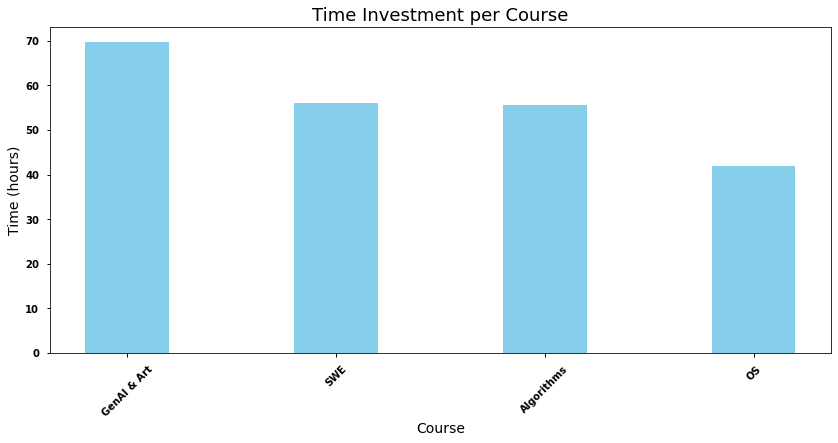

OS: 41.86 hours (18.76%)
GenAI & Art: 69.66 hours (31.22%)
SWE: 55.98 hours (25.09%)
Algorithms: 55.60 hours (24.92%)
TOTAL TIME : 223.10 hours


In [779]:
# create a bar chart of total time for all instances of a project
aggregated_data = total_time_df.groupby('Project')['Duration'].sum().reset_index()
aggregated_data = aggregated_data.sort_values(by=['Duration'], ascending=False)
plt.bar(aggregated_data['Project'], aggregated_data['Duration'], color = COLOR, 
        width = 0.4)
plt.xlabel("Course", size = 14)
plt.xticks(rotation=ROTATION)
plt.ylabel("Time (hours)", size = 14)
plt.title("Time Investment per Course", size = 18)
plt.savefig(f"../images/PerCourse.png", transparent=False, format = 'png')
plt.show()

print_string = []
for course in set(total_time_df['Project']):
    course_total_time = total_time_df[total_time_df['Project'] == course]['Duration'].sum()
    print_string.append(f"{course}: {course_total_time:.2f} hours ({(course_total_time / total_time * 100):.2f}%)")
print_string.append("TOTAL TIME : {:.2f} hours".format(total_time))
print("\n".join(print_string))
    


,Project,Type,Class Name,Duration
7,GenAI & Art,Writing,Generative AI and Artificial Intelligence,53.138056
12,SWE,Coding,Software Engineering,39.506389
8,OS,Coding,Operating Systems,32.360833
1,Algorithms,Practice,Algorithms,25.459167
0,Algorithms,Coding,Algorithms,24.033889


Coding: 95.90 hours (42.99%)
Writing: 61.83 hours (27.71%)
Practice: 35.17 hours (15.76%)
Reading: 24.07 hours (10.79%)
Research: 3.45 hours (1.54%)
Implementing: 2.39 hours (1.07%)
Assessment: 0.30 hours (0.13%)
TOTAL TIME : 223.10 hours


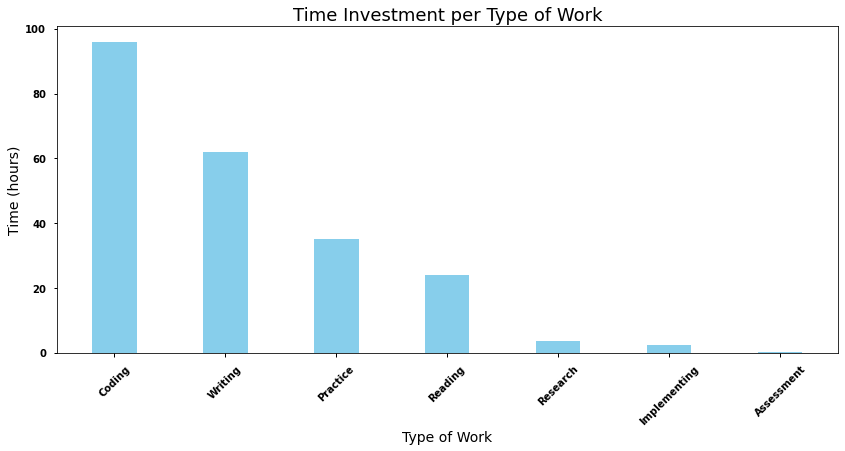

In [780]:
# create a bar chart of total time per type with the labels tilted
aggregated_data = total_time_df.groupby('Type')['Duration'].sum().reset_index()
aggregated_data = aggregated_data.sort_values(by=['Duration'], ascending=False)
plt.bar(aggregated_data['Type'], aggregated_data['Duration'], color = COLOR, 
        width = 0.4)
plt.xlabel("Type of Work", size = 14)
plt.ylabel("Time (hours)", size = 14)
plt.xticks(rotation=ROTATION)
plt.title("Time Investment per Type of Work", size = 18)
plt.savefig(f"../images/PerType.png", transparent=False, format = 'png')
display(total_time_df.head(5))

# calculate percentages of time spent on each type of work
type_time_dict = {ty:total_time_df.loc[total_time_df['Type'] == ty, 'Duration'].sum() for ty in total_time_df['Type'].unique()}
type_time_dict = {k: v for k, v in sorted(type_time_dict.items(), key=lambda item: item[1], reverse = True)}

# printing statistics
print_string = []
for ty in type_time_dict:
    type_time_dict[ty] = type_time_dict[ty] / total_time * 100
    type_total_time = total_time_df[total_time_df['Type'] == ty]['Duration'].sum()
    print_string.append(f"{ty}: {type_total_time:.2f} hours ({type_time_dict[ty]:.2f}%)")
print_string.append("TOTAL TIME : {:.2f} hours".format(total_time))
print("\n".join(print_string))


### Analysis for Individual Courses

OS


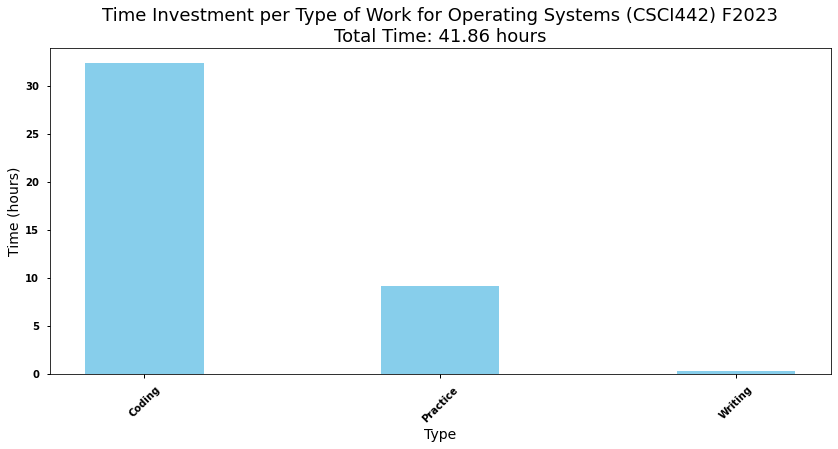

COURSE: Operating Systems (CSCI442) F2023
Coding: 32.36 hours (77.31%)
Practice: 9.20 hours (21.99%)
Writing: 0.29 hours (0.70%)
TOTAL TIME : 41.86 hours
GenAI & Art


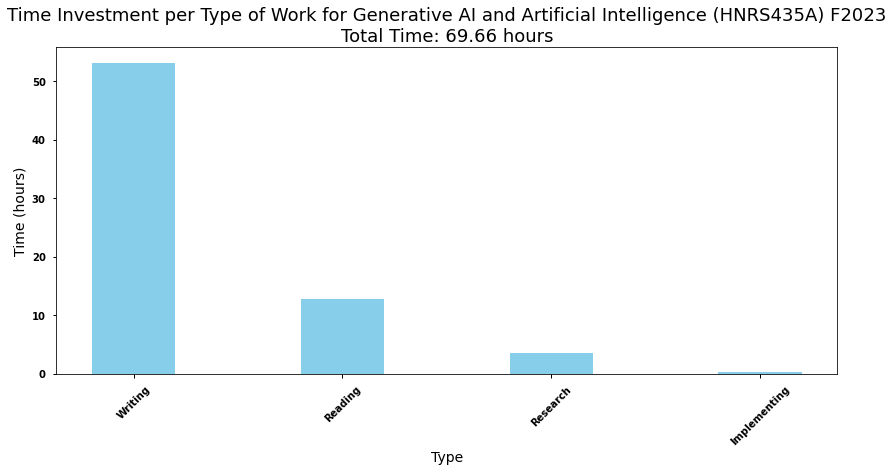

COURSE: Generative AI and Artificial Intelligence (HNRS435A) F2023
Writing: 53.14 hours (76.28%)
Reading: 12.75 hours (18.30%)
Research: 3.45 hours (4.95%)
Implementing: 0.33 hours (0.47%)
TOTAL TIME : 69.66 hours
SWE


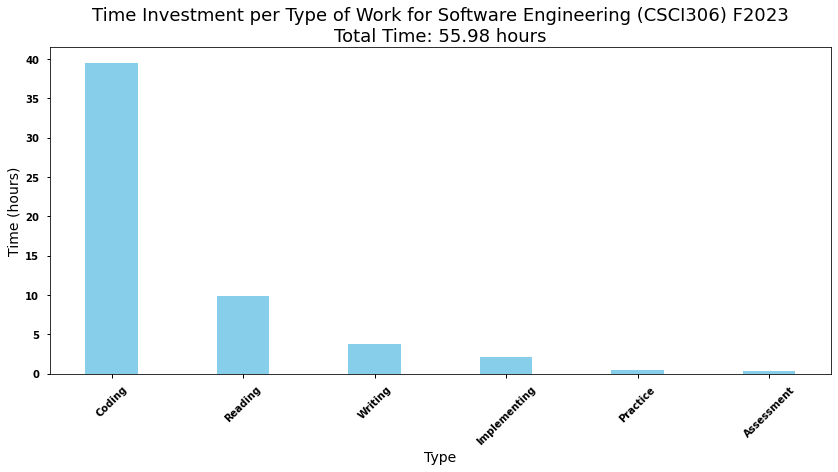

COURSE: Software Engineering (CSCI306) F2023
Coding: 39.51 hours (70.57%)
Reading: 9.86 hours (17.61%)
Writing: 3.76 hours (6.71%)
Implementing: 2.06 hours (3.68%)
Practice: 0.50 hours (0.90%)
Assessment: 0.30 hours (0.53%)
TOTAL TIME : 55.98 hours
Algorithms


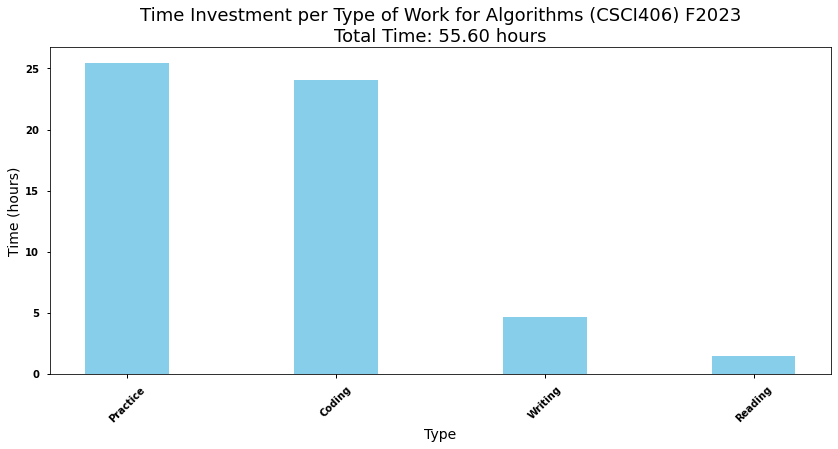

COURSE: Algorithms (CSCI406) F2023
Practice: 25.46 hours (45.79%)
Coding: 24.03 hours (43.23%)
Writing: 4.64 hours (8.35%)
Reading: 1.47 hours (2.64%)
TOTAL TIME : 55.60 hours


In [781]:
for course in set(total_time_df['Project']):
    print(course)
    print_plot(total_time_df, class_df, course, save = True)
    print(calc_stats(total_time_df, course, f))

# Time per Day

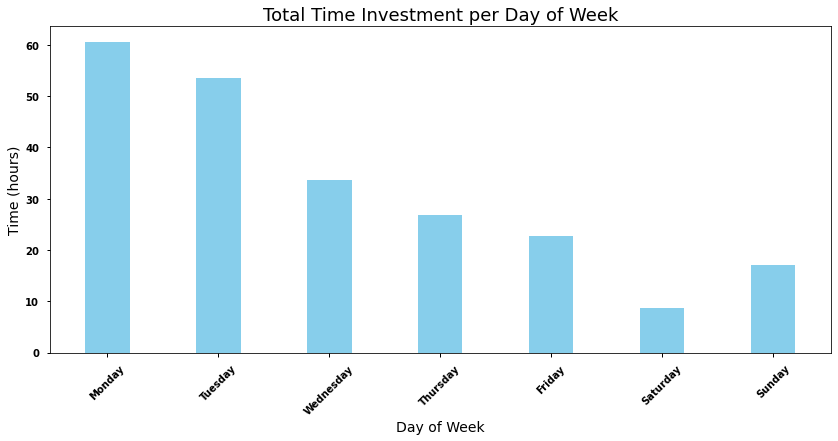

In [782]:
# using combined_df, find time spent per day of week 
combined_df['Day of Week'] = combined_df['Start date'].dt.day_name()
day_of_week_df = combined_df.groupby(['Day of Week'], as_index=False)['Duration'].sum()

# convert the duration column to hours
day_of_week_df['Duration'] = day_of_week_df['Duration'].dt.total_seconds() / 3600
day_of_week_df.head(5)

# create a column that matches Monday to 0, Tuesday to 1, etc.
day_of_week_df['Day Value'] = day_of_week_df['Day of Week'].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 
                                                                   'Thursday': 3, 'Friday': 4, 'Saturday': 5, 
                                                                   'Sunday': 6})
day_of_week_df = day_of_week_df.sort_values(by=['Day Value'])

# create a bar graph of time spent per day of week in order of day of week
plt.bar(day_of_week_df['Day of Week'], day_of_week_df['Duration'], color = COLOR, 
        width = 0.4)
plt.xlabel("Day of Week", size = 14)
plt.ylabel("Time (hours)", size = 14)
plt.xticks(rotation=ROTATION)
plt.title("Total Time Investment per Day of Week", size = 18)
plt.savefig(f"../images/PerDay.png", transparent=False, format = 'png')
plt.show()

# Post Roll 

In [783]:
f.close()